In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import davies_bouldin_score as db_score
from sklearn.metrics import silhouette_score as sil_score
from sklearn.metrics import calinski_harabasz_score as cal_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data_filtre.csv')

In [3]:
data

customer_zip_code_prefix       customer_city customer_state   
0                          7787             cajamar             SP  \
1                          6053              osasco             SP   
2                         88115            sao jose             SC   
3                         66812               belem             PA   
4                         18040            sorocaba             SP   
...                         ...                 ...            ...   
92488                     55250             sanharo             PE   
92489                     44054    feira de santana             BA   
92490                     78552               sinop             MT   
92491                     29460  bom jesus do norte             ES   
92492                     83608         campo largo             PR   

       geolocation_lat  geolocation_lng  frequency  days_late  recency   
0           -23.335331       -46.828647          1       -5.0    153.0  \
1           -23.567395       -46.792957          1       -5.0    159.0   
2           -27.543787       -48.625680          1       -2.0    559.0   
3            -1.311011       -48.482884          1      -12.0    349.0   
4           -23.504368       -47.466156          1       -8.0    323.0   
...                ...              ...        ...        ...      ...   
92488        -8.363166       -36.559088          1      -27.0    468.0   
92489       -12.221792       -38.962517          1       -3.0    280.0   
92490       -11.829317       -55.496443          1      -30.0    602.0   
92491       -21.125061       -41.666268          1      -14.0    156.0   
92492       -25.456502       -49.435381          1      -16.0    525.0   

       number_of_items    price  freight_value  payment_installments   
0                    1   129.90          12.00                     8  \
1                    1    18.90           8.29                     1   
2                    1    69.00          17.22                     8   
3                    1    25.99          17.63                     4   
4                    1   180.00          16.89                     6   
...                ...      ...            ...                   ...   
92488                2  1570.00         497.42                    10   
92489                1    64.89          19.69                     1   
92490                1    89.90          22.56                     1   
92491                1   115.00          18.69                     5   
92492                1    56.99          14.57                     4   

       monetary  review_score  
0        141.90           5.0  
1         27.19           4.0  
2         86.22           3.0  
3         43.62           4.0  
4        196.89           5.0  
...         ...           ...  
92488   2067.42           5.0  
92489     84.58           4.0  
92490    112.46           5.0  
92491    133.69           5.0  
92492     71.56           5.0  

[92493 rows x 14 columns]

In [4]:
data.dtypes

customer_zip_code_prefix      int64
customer_city                object
customer_state               object
geolocation_lat             float64
geolocation_lng             float64
frequency                     int64
days_late                   float64
recency                     float64
number_of_items               int64
price                       float64
freight_value               float64
payment_installments          int64
monetary                    float64
review_score                float64
dtype: object

# Sommaire

## <a href="#0"> Création des fonctions

## <a href="#1"> Dataset RFM
  -  <a href="#1a"> Normalisation
  -  <a href="#1b"> KMeans
  -  <a href="#1c"> DBSCAN
  -  <a href="#1d"> Agglomerative Clustering
  -  <a href="#1e"> Résultats
    
## <a href="#2"> Dataset RFM sans les clients uniques
  - <a href="#2a"> KMeans
  - <a href="#2b"> DBSCAN
  - <a href="#2c"> Agglomerative Clustering
 
## <a href="#3"> Dataset RFM + reviews 
  - <a href="#3a"> KMeans
  - <a href="#3b"> DBSCAN
  - <a href="#3c"> Agglomerative Clustering
 
## <a href="#4"> Dataset RFM + reviews + payment_installments
  - <a href="#4a"> KMeans
  - <a href="#4b"> DBSCAN
  - <a href="#4c"> Agglomerative Clustering
    
## <a href="#5"> Dataset RFM + reviews + days_late
  - <a href="#5a"> KMeans
  - <a href="#5b"> DBSCAN
  - <a href="#5c"> Agglomerative Clustering
    
## <a href="#6"> Comparaison
    
## <a href="#7"> Hyper-paramètres et stabilité

# <a name="0"> Création des fonctions

In [5]:
def score_clusters(data):
    '''Calcul des scores d'inertie, de silhouette,
    de Calinski-Harabasz et de Davies-Bouldin
    en fonction du nombre de clusters.
    '''

    inertia = []
    silhouette = []
    calinski = []
    davies = []
    K_range = range(2, 12)
    for k in K_range:
        model = KMeans(random_state = 0, n_clusters=k).fit(data)
        inertia.append(model.inertia_)
        silhouette.append(sil_score(data, model.labels_))
        calinski.append(cal_score(data, model.labels_))
        davies.append(db_score(data, model.labels_))
    return [inertia, silhouette, calinski, davies]

In [6]:
def affichage_scores(data):
    '''Affichage des scores en fonction du nombre de clusters.'''

    scores = score_clusters(data)
    fig, axs = plt.subplots(2,2)
    noms = ['inertia', 'silhouette', 'Calinski Harabasz', 'Davies Bouldin']
    s = 0
    K_range = range(2, 12)
    for row in [0,1]:
        for col in [0,1]:
            axs[row,col].plot(K_range, scores[s])
            axs[row,col].set_xlabel('nombre de clusters')
            axs[row,col].set_ylabel(noms[s])
            s += 1
    fig.set_figheight(8)
    fig.set_figwidth(10)
    plt.show()

In [7]:
def affichage_clusters_3d(x, y, z, X, model):
    '''Affichage en 3 dimensions des clusters selon le model
    sur le dataset X et les features x, y, z.
    '''

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter3D(X[x], X[y], X[z], c = model.labels_)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title('Clusters avec '+ str(model))

    plt.show()

In [8]:
def affichage_clusters_2d(data, model):
    '''Affichage des clusters en 2 dimensions selon le model
    en prenant toutes les combinaisons de 2 features dans data.
    '''

    liste = data.columns.tolist()
    for x in liste :
        liste_bis = liste.copy()
        liste_bis.remove(x)
        for y in liste_bis :
            fig = plt.figure(figsize = (4,3))
            ax = plt.axes()

            ax.scatter(X[x], X[y], c = model.labels_)

            ax.set_xlabel(x)
            ax.set_ylabel(y)
            ax.set_title('Clusters avec '+ str(model))

            plt.show()

In [9]:
def affichage_centres_3d(x, y, z, model):
    '''Affichage en 3 dimensions des centroïdes de kmeans
    en fonction de l'index des features x, y et z.
    '''

    centres_nrm = model.cluster_centers_
    centres = std.inverse_transform(centres_nrm)

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.scatter3D(centres[:,x], centres[:,y], centres[:,z])

    ax.set_xlabel(X.columns[x])
    ax.set_ylabel(X.columns[y])
    ax.set_zlabel(X.columns[z])
    ax.set_title('Centres des clusters')

    for i in range(len(centres)):
        ax.text(centres[i][x], centres[i][y], centres[i][z], 'C' + str(i))

    plt.show()

    print(centres)

In [10]:
def affichage_centres_2d(x, y):
    '''Affichage en 2 dimensions des centroïdes de kmeans
    en fonction de l'index des features x et y.
    '''

    centres_nrm = model_kmeans.cluster_centers_
    centres = std.inverse_transform(centres_nrm)

    plt.scatter(centres[:,x], centres[:,y])

    for i in range(len(centres)):
        plt.text(x = centres[i][x], y = centres[i][y], s = 'C' + str(i))

    plt.xlabel(X.columns[x])
    plt.ylabel(X.columns[y])
    plt.title('Centres des clusters')

    plt.show()

In [11]:
def calcul_centres_model(model):
    '''Calcul des centroïdes de DBSCAN ou AggloAgglomerativeClustering.'''

    labels = model.labels_
    centroids = []
    for label in set(labels):
        if label != -1:
            mask = labels == label
            cluster_points = X[mask]
            centroid = cluster_points.mean(axis=0)
            centroids.append(centroid)
    return centroids

def affichage_centres_model_3d(x, y, z, model):
    '''
    Affichage en 3 dimensions des centroïdes de DBSCAN ou
    AggloAgglomerativeClustering.
    en fonction de l'index des features x, y, z.
    '''

    centres = calcul_centres_model(model)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
   
    ax.scatter3D([centres[i][x] for i in range(len(centres))], 
                 [centres[i][y] for i in range(len(centres))],
                 [centres[i][z] for i in range(len(centres))])

    ax.set_xlabel(centres[0].index[x])
    ax.set_ylabel(centres[0].index[y])
    ax.set_zlabel(centres[0].index[z])
    ax.set_title('Centres des clusters')

    for i in range(len(centres)):
        ax.text(centres[i][x], centres[i][y], centres[i][z], 'C' + str(i))

    plt.show()

def affichage_centres_model_2d(x, y, model):
    '''
    Affichage en 2 dimensions des centroïdes de DBSCAN ou
    AggloAgglomerativeClustering.
    en fonction de l'index des features x et y.
    '''

    centres = calcul_centres_model(model)

    fig = plt.figure()
    ax = plt.axes()

    ax.scatter([centres[i][x] for i in range(len(centres))], 
               [centres[i][y] for i in range(len(centres))])

    ax.set_xlabel(centres[0].index[x])
    ax.set_ylabel(centres[0].index[y])

    ax.set_title('Centres des clusters')

    for i in range(len(centres)):
        ax.text(centres[i][x], centres[i][y], 'C' + str(i))

    plt.show()

In [12]:
def scores_finaux(data, model):
    '''Calcul des scores du model choisi sur data.'''

    for metric in [db_score, sil_score, cal_score] :
        return [db_score(data, model.labels_), sil_score(data, model.labels_), cal_score(data, model.labels_)]

# <a name="1"> Dataset RFM

In [13]:
X = data[['recency','frequency','monetary']]

## <a name="1a"> Normalisation

In [14]:
std = StandardScaler()
X_nrm = std.fit_transform(X)

## <a name="1b"> KMeans

### Calcul et affichage des différents scores selon le nombre de clusters

Le score inertia est la somme des distances carrées entre chaque point et le centroid de son cluster.

Le score silhouette mesure la différence moyenne entre la distance moyenne d'un point à tous les autres points dans le même cluster et la distance moyenne de ce point à tous les points dans le cluster le plus proche. Les différences sont ensuite normalisées.

Le score Davies-Bouldin mesure la moyenne des similarités intra-clusters entre chaque paire de clusters, divisée par la similarité inter-cluster maximale entre les clusters.

Le score Calinski-Harabasz mesure la variance entre les clusters divisée par la variance intra-cluster.

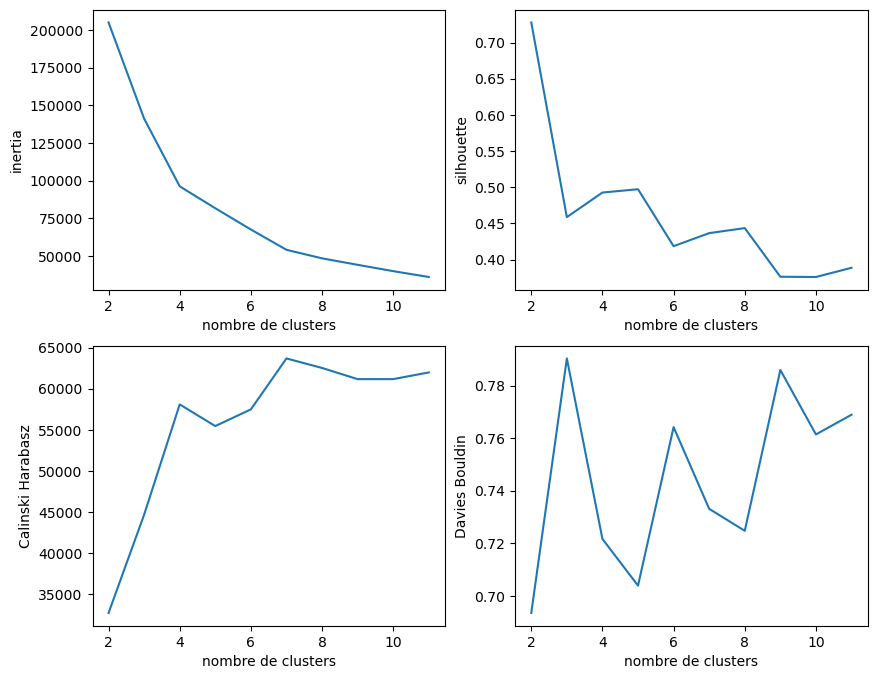

In [15]:
affichage_scores(X_nrm)

Les scores d'inertie et de Calinski-Harabasz nous orientent vers un choix de 7 clusters.

Les scores de silhouette et de Davies-Bouldin nous orientent vers un choix de 5 clusters.

### Clustering 

In [16]:
model_kmeans = KMeans(random_state = 0, n_clusters=5)
model_kmeans.fit(X_nrm)

KMeans(n_clusters=5, random_state=0)

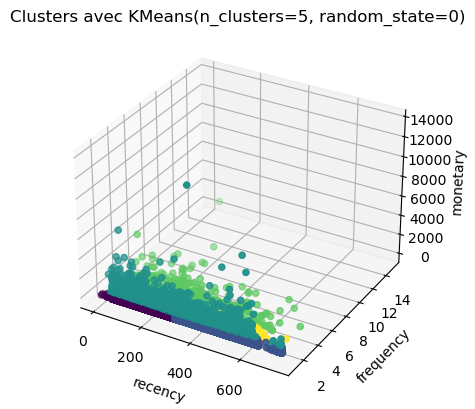

In [17]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X, model_kmeans)

In [18]:
# Regardons les effectifs de chaque cluster

pd.Series(model_kmeans.labels_).value_counts()

0    53308
1    33959
2     2428
4     2282
3      516
Name: count, dtype: int64

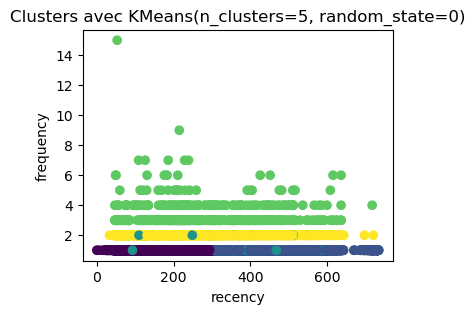

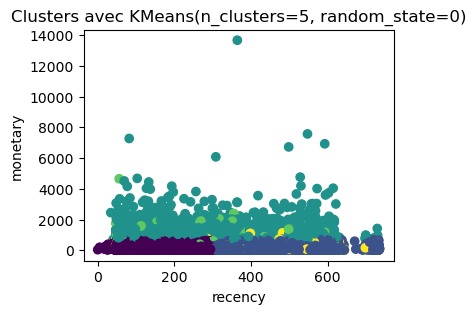

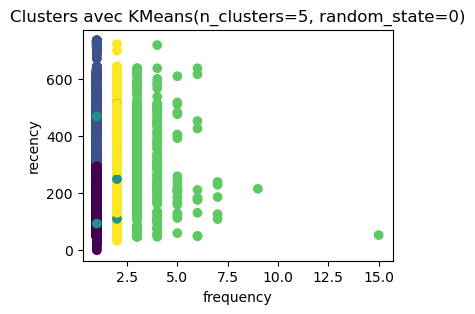

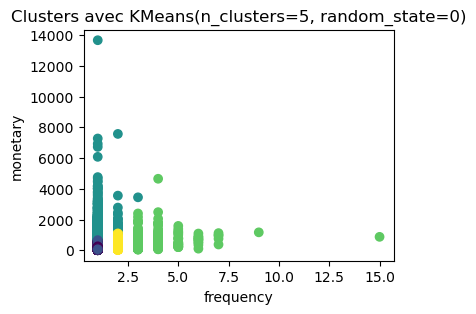

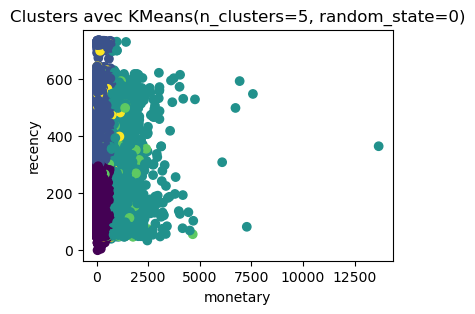

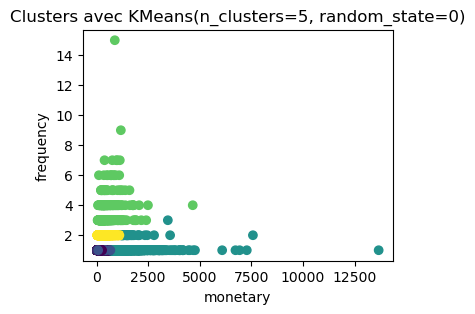

In [19]:
affichage_clusters_2d(X, model_kmeans)

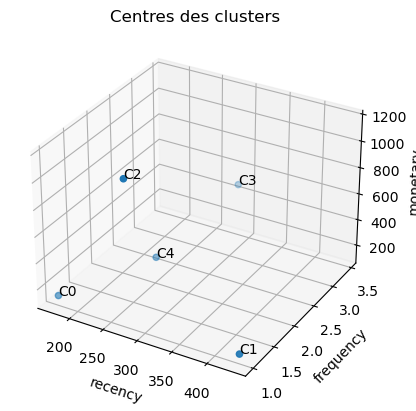

[[1.71184772e+02 1.00000000e+00 1.34679925e+02]
 [4.34404258e+02 1.00000000e+00 1.32310806e+02]
 [2.71562140e+02 1.01975309e+00 1.15303428e+03]
 [2.85860465e+02 3.44767442e+00 4.76386880e+02]
 [2.51764242e+02 2.00000000e+00 2.62687967e+02]]


In [20]:
affichage_centres_3d(0, 1, 2, model_kmeans)

Les 5 centres :

    - C0 représente le cluster des clients récents occasionnels qui ont acheté pour un petit montant
    - C1 représente le cluster des anciens clients. Ils sont occasionnels et ont acheté pour un petit montant
    - C2 représente le cluster des clients récents plus dépensiers
    - C3 représente le cluster des clients plus dépensiers et fidèles
    - C4 représente le cluster des clients récents et fidèles

### Scores

In [21]:
resultats = pd.DataFrame(index = ['Davies_bouldin','Silhouette',
                                  'calinski_harabasz'])

In [22]:
resultats['KMeans'] = scores_finaux(X_nrm, model_kmeans)
resultats

KMeans
Davies_bouldin         0.703858
Silhouette             0.497163
calinski_harabasz  55445.270254

## <a name="1c"> DBSCAN

In [23]:
model_dbscan = DBSCAN()
model_dbscan.fit(X_nrm)

DBSCAN()

In [24]:
labels = model_dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 13
Estimated number of noise points: 168


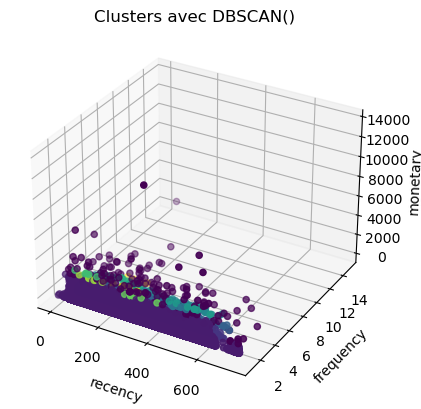

In [25]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X, model_dbscan)

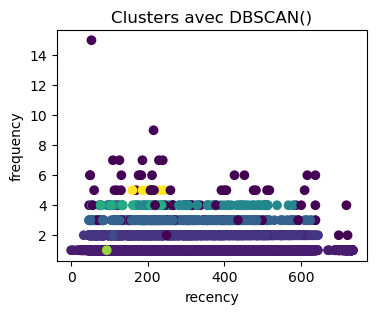

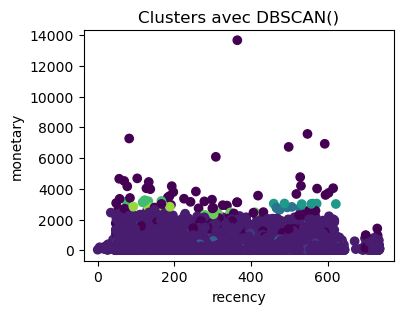

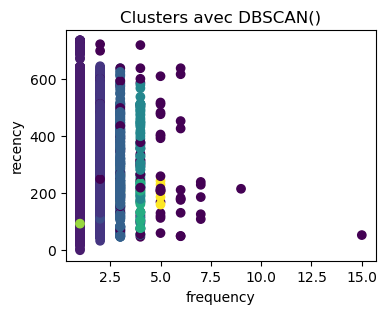

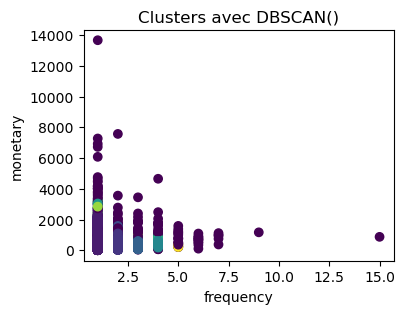

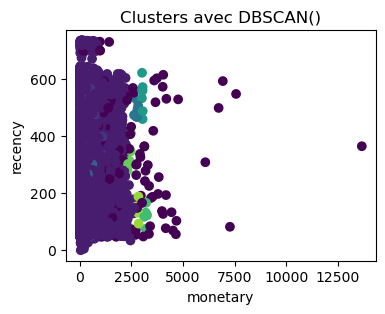

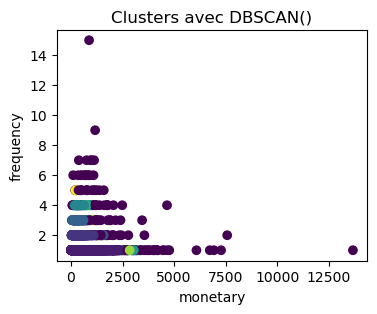

In [26]:
affichage_clusters_2d(X, model_dbscan)

In [27]:
resultats['DBSCAN'] = scores_finaux(X_nrm, model_dbscan)
resultats

KMeans       DBSCAN
Davies_bouldin         0.703858     1.372827
Silhouette             0.497163     0.659996
calinski_harabasz  55445.270254  3896.545566

## <a name="1d"> Agglomerative Clustering

In [28]:
# Je ne prends qu'un échantillon de 10%

X_sample = X.sample(frac = 0.1, random_state = 0)
X_nrm_sample = std.fit_transform(X_sample)

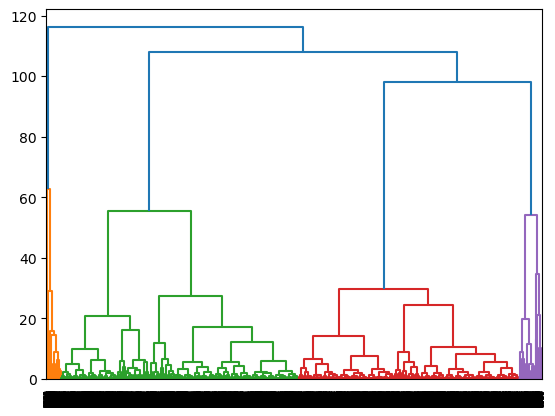

In [29]:
linkage_matrix = linkage(X_nrm_sample, method='ward')
dendrogram(linkage_matrix)
plt.show()

In [30]:
model_hac = AgglomerativeClustering(n_clusters = 4)
model_hac.fit(X_nrm_sample)

AgglomerativeClustering(n_clusters=4)

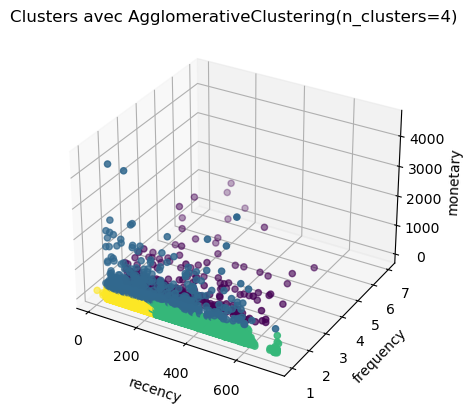

In [31]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X_sample, model_hac)

In [32]:
resultats['AgglomerativeClustering'] = scores_finaux(X_nrm_sample, model_hac)

## <a name="1e"> Résultats

In [33]:
resultats

KMeans       DBSCAN  AgglomerativeClustering
Davies_bouldin         0.703858     1.372827                 0.776409
Silhouette             0.497163     0.659996                 0.460955
calinski_harabasz  55445.270254  3896.545566              5168.318086

AgglomerativeClustering a le meilleur score de Davies-Bouldin, DBSCAN a le meilleur score de Silhouette et KMeans a le meilleur score de Calinski.

# <a name="2"> Dataset RFM sans les clients uniques

In [34]:
X = data.loc[data['frequency'] > 1, ['recency','frequency','monetary']]

## Normalisation

In [35]:
X_nrm = std.fit_transform(X)

## <a name="2a"> KMeans

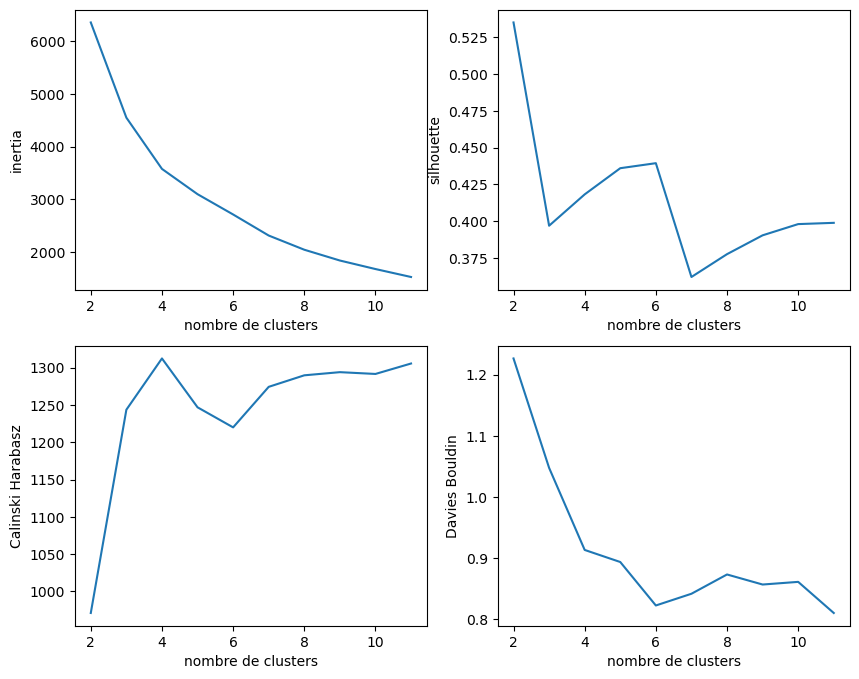

In [36]:
affichage_scores(X_nrm)

Le score d'inertie nous oriente vers un choix de 7 clusters.

Le score de Calinski-Harabasz nous oriente vers un choix de 4 clusters.

Les scores de silhouette et de Davies Bouldin nous orientent vers un choix de 6 clusters.

In [37]:
model_kmeans = KMeans(random_state = 0, n_clusters = 6)
model_kmeans.fit(X_nrm)

KMeans(n_clusters=6, random_state=0)

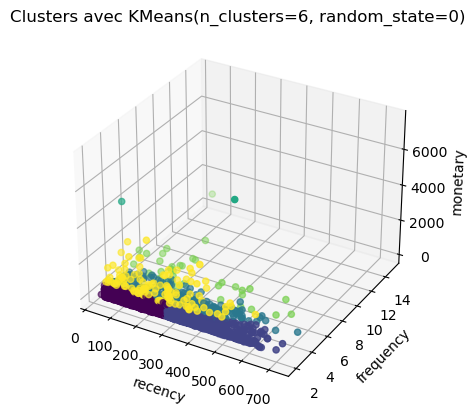

In [38]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X, model_kmeans)

In [39]:
# Regardons les effectifs de chaque cluster

pd.Series(model_kmeans.labels_).value_counts()

0    1414
1     879
2     392
5     117
4      41
3       2
Name: count, dtype: int64

In [40]:
# Ce n'est pas satisfaisant
# Recommençons avec 4 clusters

model_kmeans = KMeans(random_state = 0, n_clusters = 4)
model_kmeans.fit(X_nrm)

KMeans(n_clusters=4, random_state=0)

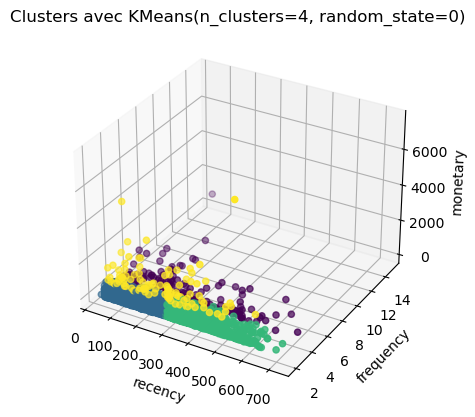

In [41]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X, model_kmeans)

In [42]:
# Regardons les effectifs de chaque cluster

pd.Series(model_kmeans.labels_).value_counts()

1    1596
2     999
0     146
3     104
Name: count, dtype: int64

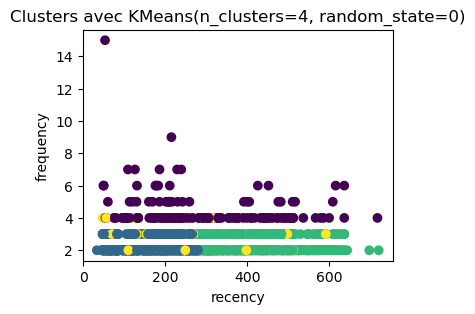

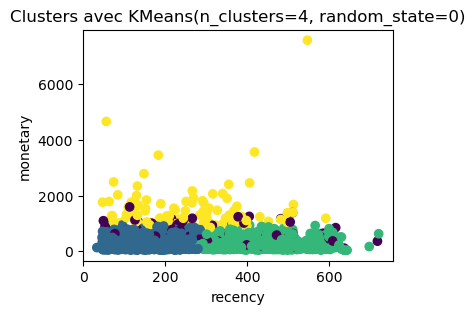

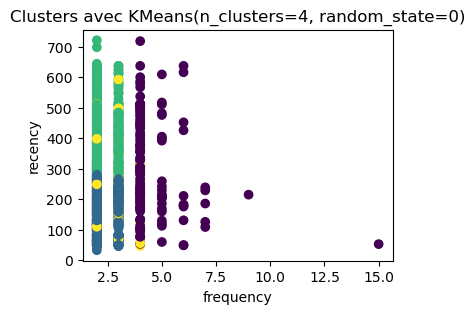

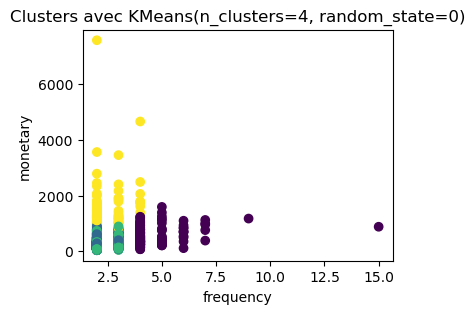

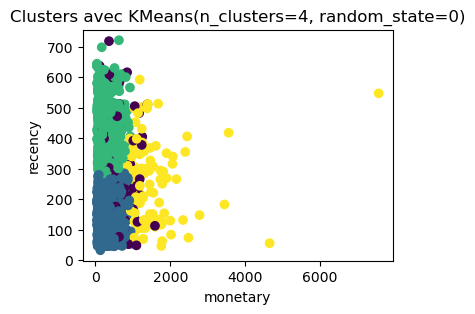

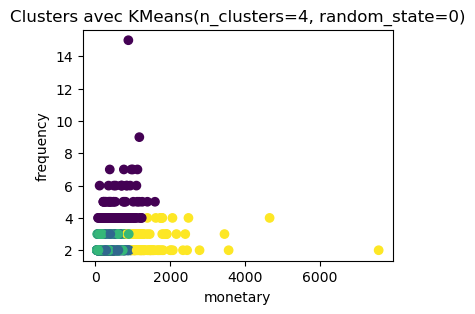

In [43]:
affichage_clusters_2d(X, model_kmeans)

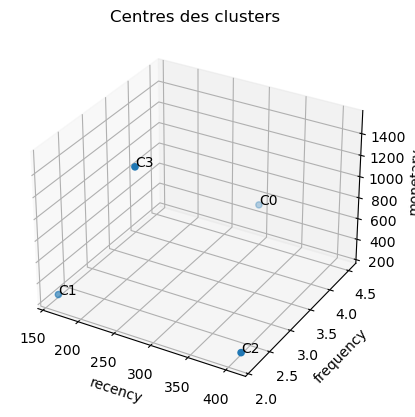

[[ 297.9109589     4.52054795  543.60828767]
 [ 160.80513784    2.11466165  271.40554511]
 [ 407.57557558    2.15215215  256.70998999]
 [ 251.36538462    2.43269231 1519.10432692]]


In [44]:
affichage_centres_3d(0, 1, 2, model_kmeans)

Les 4 centres :

    - C0 représente le cluster des clients réguliers
    - C1 représente le cluster des clients récents. Ils ont acheté pour un petit montant
    - C2 représente le cluster des anciens clients. Ils ont acheté pour un petit montant 
    - C3 représente le cluster des clients les plus dépensiers. Ils sont récents et fréquents

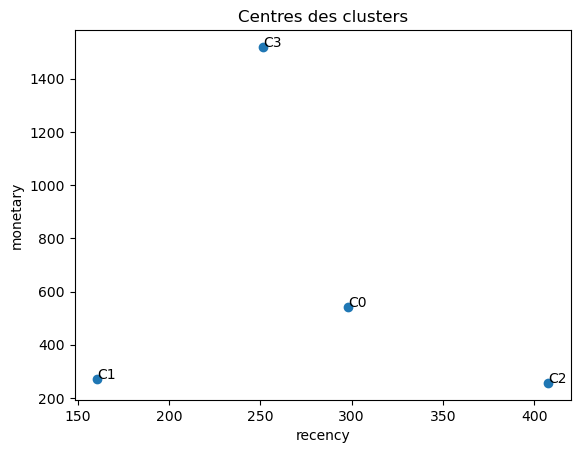

In [45]:
# Regardons en 2 dimensions

affichage_centres_2d(0, 2)

In [46]:
resultats_rfm_réduit = pd.DataFrame(index = ['Davies_bouldin','Silhouette','calinski_harabasz'])
resultats_rfm_réduit['KMeans'] = scores_finaux(X_nrm,model_kmeans)
resultats_rfm_réduit

KMeans
Davies_bouldin        0.913029
Silhouette            0.418257
calinski_harabasz  1312.290525

### <a name="2b"> DBSCAN

In [47]:
model_dbscan = DBSCAN()
model_dbscan.fit(X_nrm)

DBSCAN()

In [48]:
labels = model_dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 84


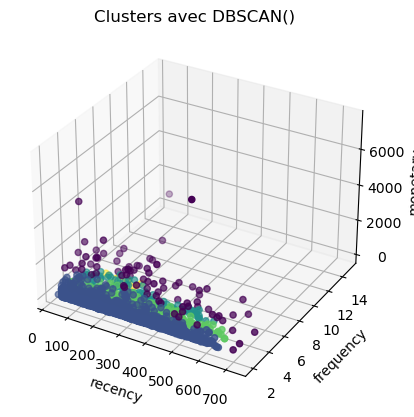

In [49]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X, model_dbscan)

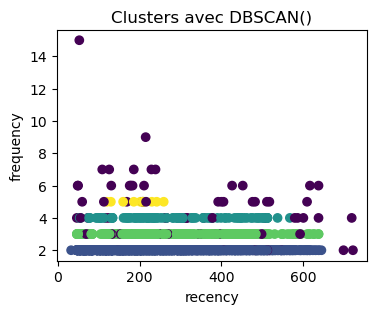

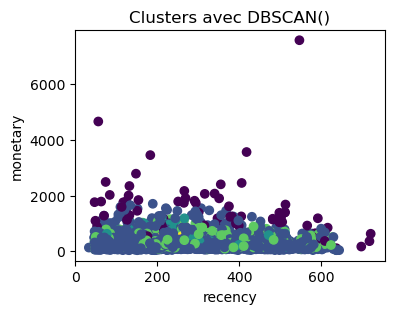

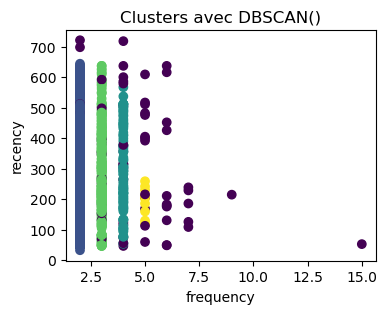

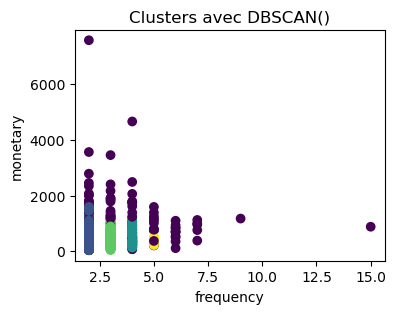

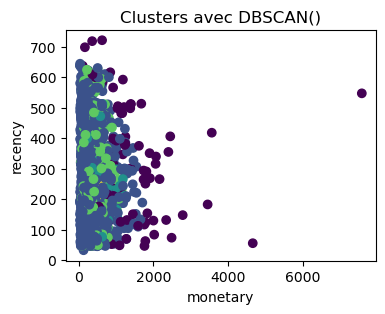

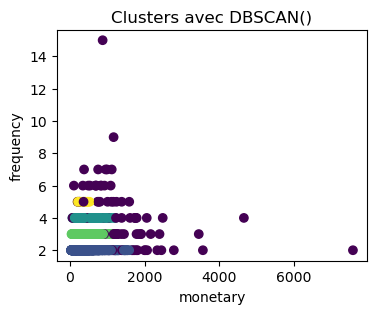

In [50]:
affichage_clusters_2d(X, model_dbscan)

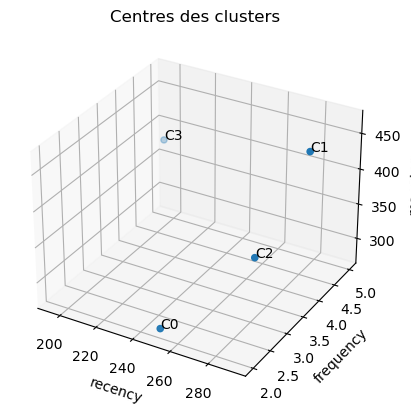

In [51]:
affichage_centres_model_3d(0, 1, 2, model_dbscan)

In [52]:
resultats_rfm_réduit['DBSCAN'] = scores_finaux(X_nrm,model_dbscan)
resultats_rfm_réduit

KMeans      DBSCAN
Davies_bouldin        0.913029    1.511969
Silhouette            0.418257    0.326821
calinski_harabasz  1312.290525  393.265711

### <a name="2c"> Agglomerative Clustering

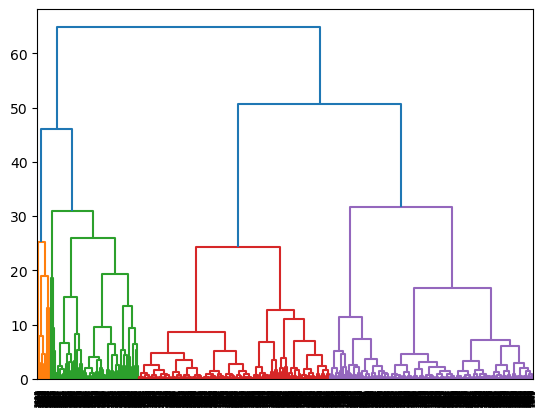

In [53]:
linkage_matrix = linkage(X_nrm, method='ward')
dendrogram(linkage_matrix)
plt.show()

In [54]:
model_hac = AgglomerativeClustering(n_clusters = 4)
model_hac.fit(X_nrm)

AgglomerativeClustering(n_clusters=4)

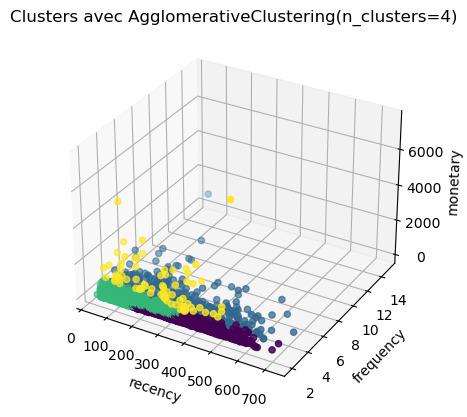

In [55]:
affichage_clusters_3d('recency', 'frequency', 'monetary', X, model_hac)

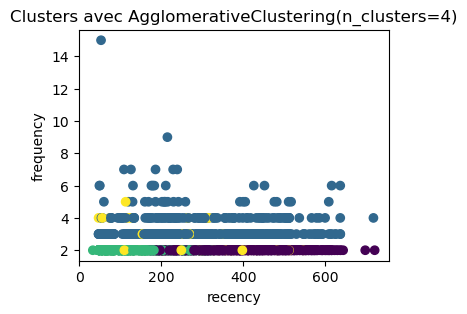

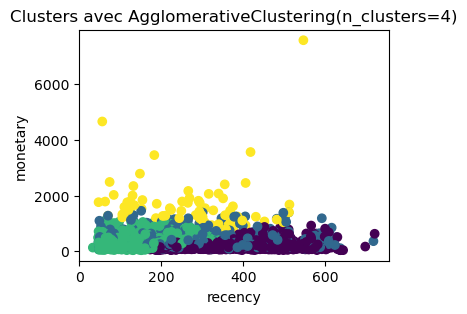

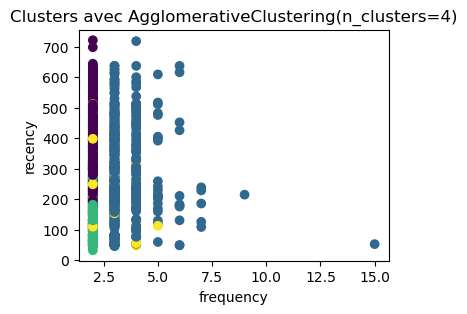

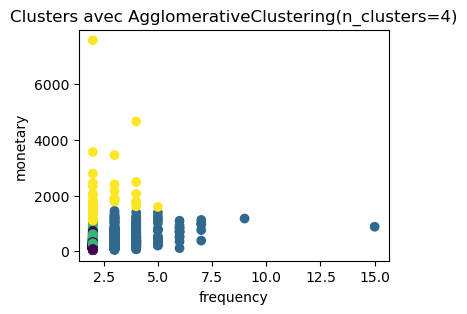

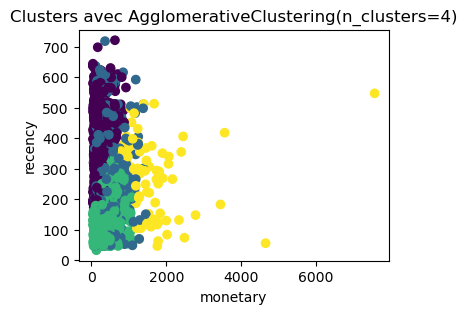

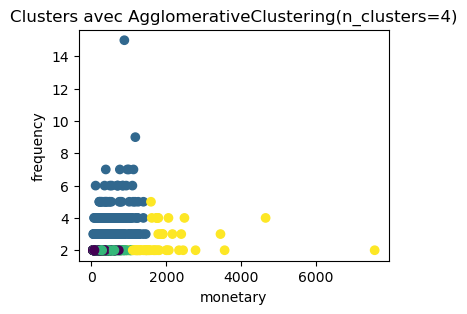

In [56]:
affichage_clusters_2d(X, model_hac)

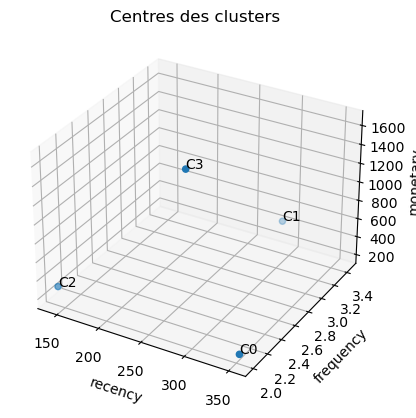

In [57]:
affichage_centres_model_3d(0, 1, 2, model_hac)

In [58]:
resultats_rfm_réduit['model_hac'] = scores_finaux(X_nrm,model_hac)
resultats_rfm_réduit

KMeans      DBSCAN    model_hac
Davies_bouldin        0.913029    1.511969     0.994857
Silhouette            0.418257    0.326821     0.317567
calinski_harabasz  1312.290525  393.265711  1031.739537

KMeans a les meilleurs résultats

# <a name="3"> Dataset RFM + reviews 

In [59]:
X = data[['recency','frequency','monetary','review_score']]

In [60]:
std = StandardScaler()
X_nrm = std.fit_transform(X)

### <a name="3a"> KMeans 

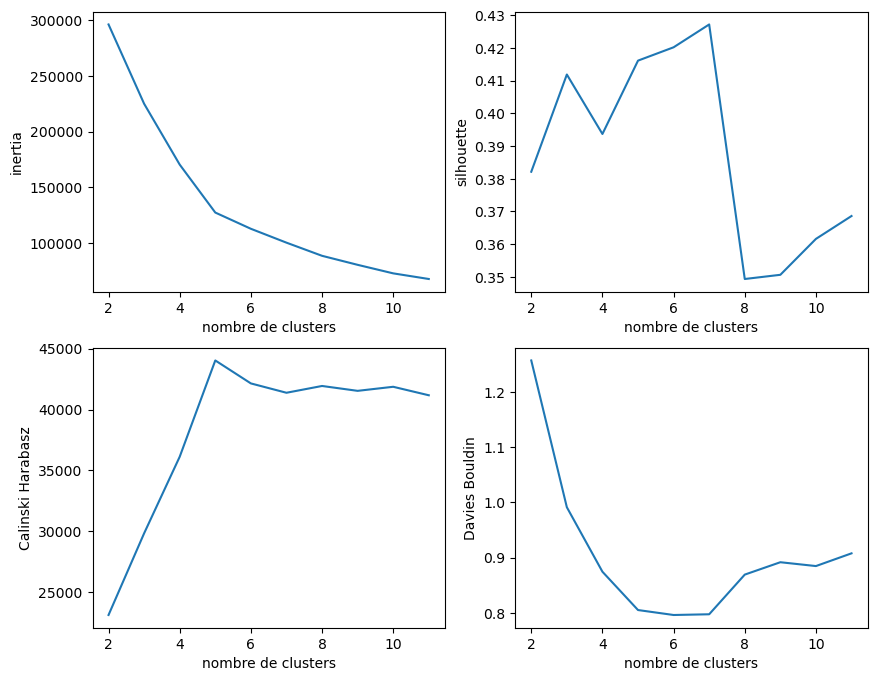

In [61]:
affichage_scores(X_nrm)

Les scores d'inertie et de Calinski-Harabasz nous orientent vers un choix de 5 clusters.

Les scores de silhouette et de Davies-Bouldin nous orientent vers un choix de 6 clusters.

In [62]:
model_kmeans = KMeans(random_state = 0, n_clusters = 5)
model_kmeans.fit(X_nrm)

KMeans(n_clusters=5, random_state=0)

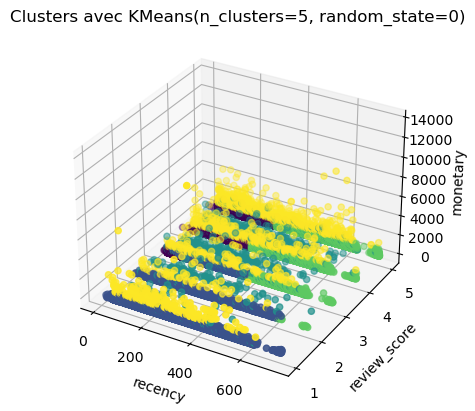

In [63]:
affichage_clusters_3d('recency', 'review_score', 'monetary', X, model_kmeans)

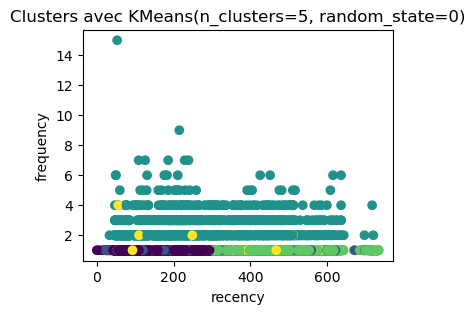

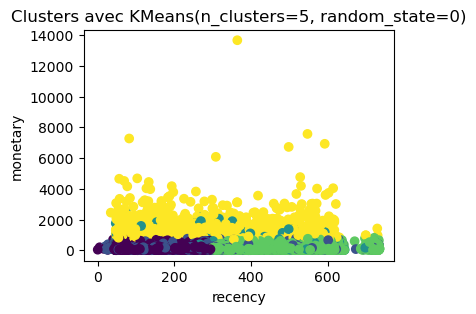

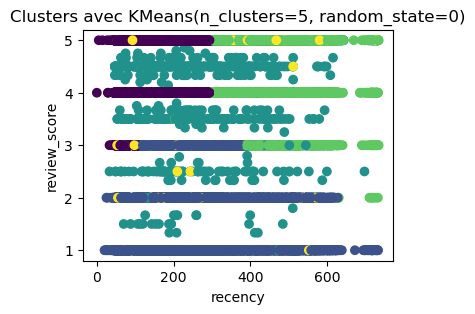

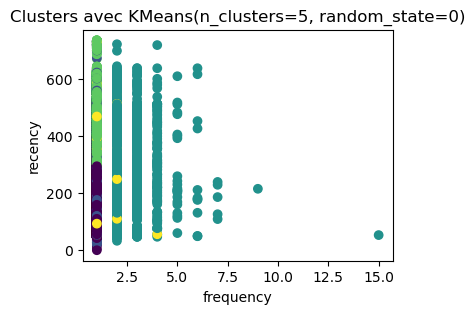

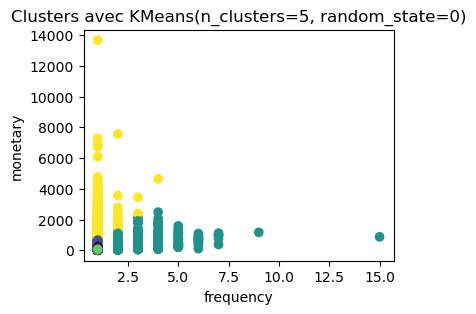

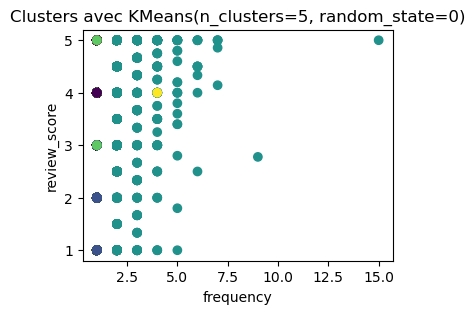

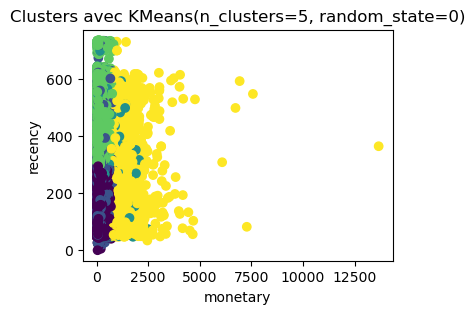

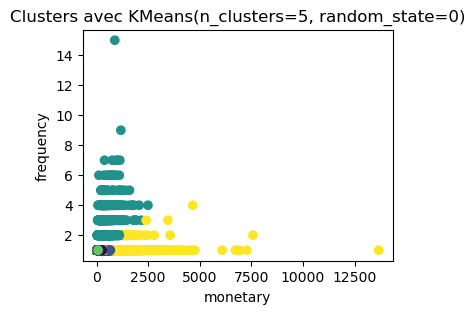

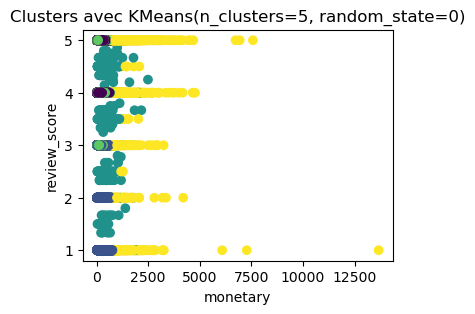

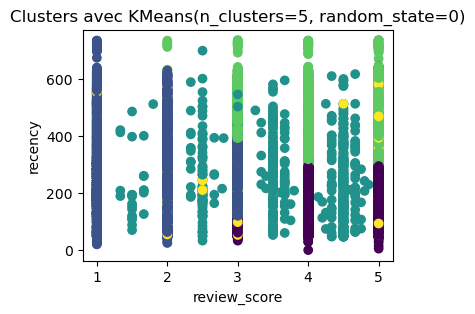

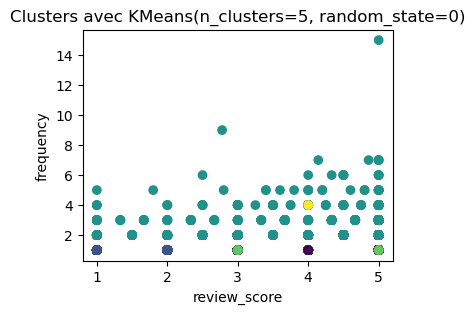

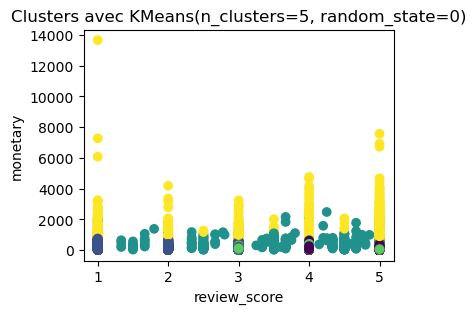

In [64]:
affichage_clusters_2d(X, model_kmeans)

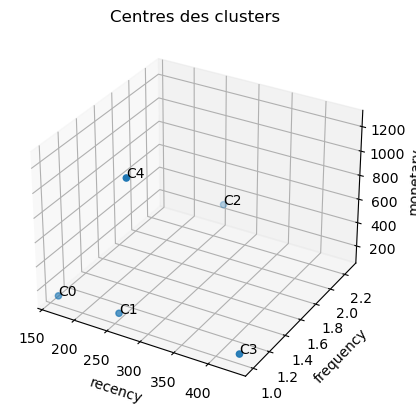

[[1.63011228e+02 1.00000000e+00 1.33222091e+02 4.71488808e+00]
 [2.56441067e+02 1.00000000e+00 1.50779635e+02 1.74792577e+00]
 [2.58089771e+02 2.26609442e+00 2.99790122e+02 4.20529725e+00]
 [4.33741560e+02 1.00000000e+00 1.33399856e+02 4.63655808e+00]
 [2.68396030e+02 1.02630273e+00 1.24939445e+03 4.08089330e+00]]


In [65]:
affichage_centres_3d(0, 1, 2, model_kmeans)

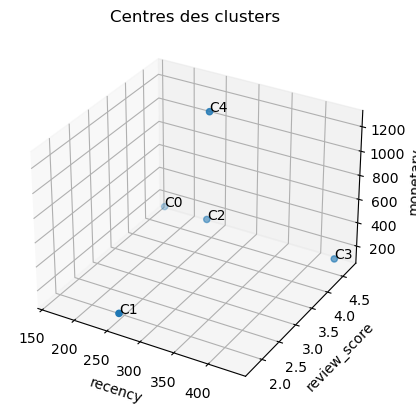

[[1.63011228e+02 1.00000000e+00 1.33222091e+02 4.71488808e+00]
 [2.56441067e+02 1.00000000e+00 1.50779635e+02 1.74792577e+00]
 [2.58089771e+02 2.26609442e+00 2.99790122e+02 4.20529725e+00]
 [4.33741560e+02 1.00000000e+00 1.33399856e+02 4.63655808e+00]
 [2.68396030e+02 1.02630273e+00 1.24939445e+03 4.08089330e+00]]


In [66]:
affichage_centres_3d(0, 3, 2, model_kmeans)

Les 5 centres :

    - C0 représente les clusters des clients récents, occasionnels, peu dépensiers et satisfaits
    - C1 représente les clusters des clients insatisfaits
    - C2 représente les clusters des clients réguliers.
    - C3 représente les clusters des anciens clients. Ils sont occasionnels, peu dépensiers et satisfaits
    - C4 représente les clusters des clients les plus dépensiers
    

### <a name="3b"> DBSCAN

In [67]:
model_dbscan = DBSCAN()
model_dbscan.fit(X_nrm)

DBSCAN()

In [68]:
labels = model_dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 25
Estimated number of noise points: 458


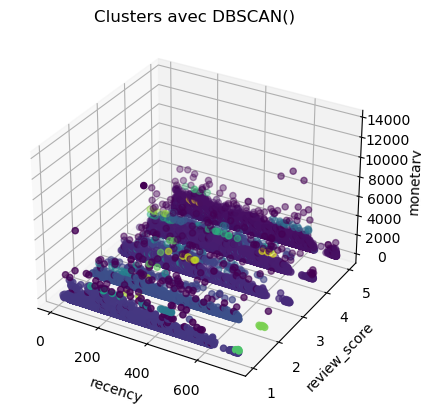

In [69]:
affichage_clusters_3d('recency', 'review_score', 'monetary', X, model_dbscan)

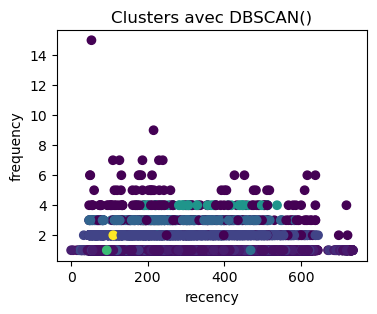

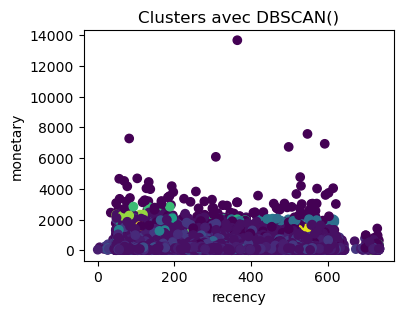

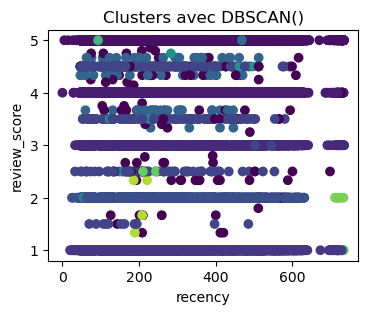

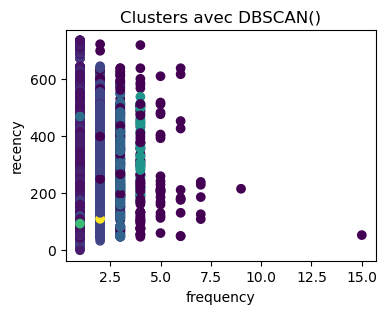

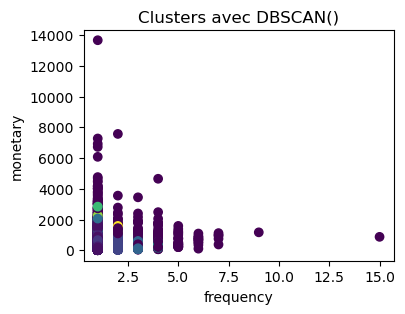

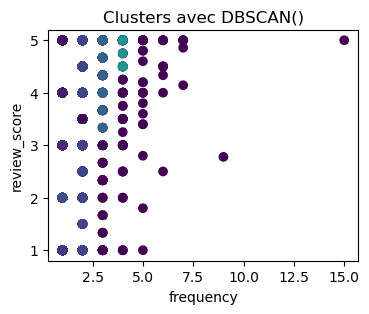

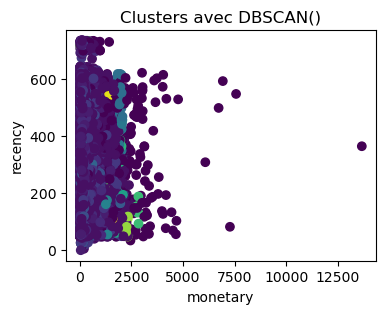

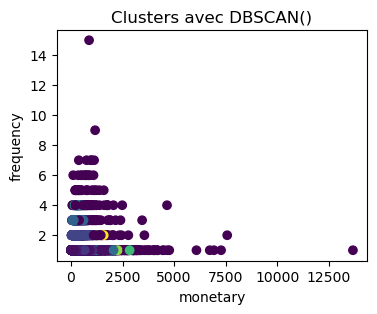

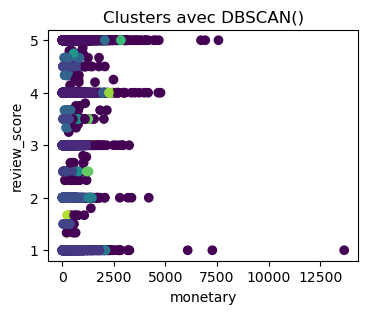

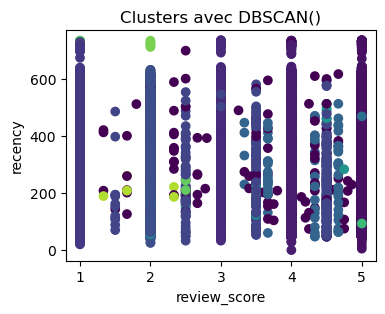

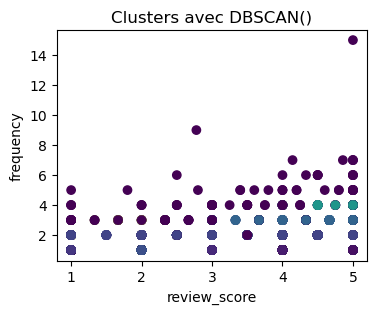

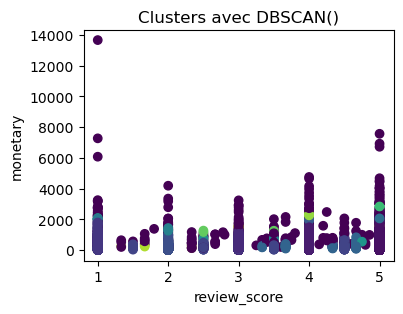

In [70]:
affichage_clusters_2d(X, model_dbscan)

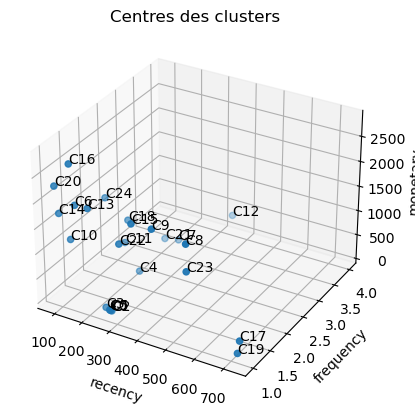

In [71]:
affichage_centres_model_3d(0,1,2, model_dbscan)

### <a name="3c"> Agglomerative clustering

In [72]:
# Je ne prends qu'un échantillon de 10%

X_sample = X.sample(frac = 0.1, random_state = 0)
X_nrm_sample = std.fit_transform(X_sample)

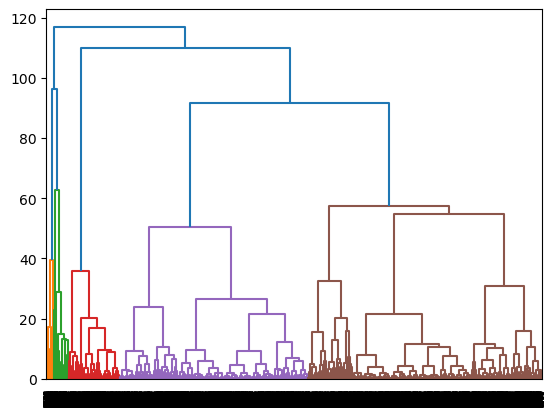

In [73]:
linkage_matrix = linkage(X_nrm_sample, method='ward')
dendrogram(linkage_matrix) 
plt.show()

In [74]:
model_hac = AgglomerativeClustering(n_clusters = 5)
model_hac.fit(X_nrm_sample)

AgglomerativeClustering(n_clusters=5)

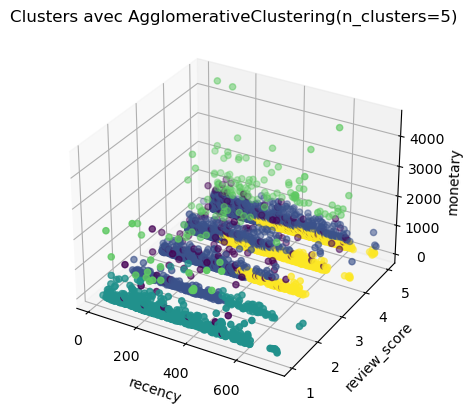

In [75]:
affichage_clusters_3d('recency', 'review_score', 'monetary', X_sample, model_hac)

In [76]:
resultats_rfm_reviews = pd.DataFrame(index = ['Davies_bouldin',
                                              'Silhouette','calinski_harabasz'])
resultats_rfm_reviews['KMeans'] = scores_finaux(X_nrm,model_kmeans)
resultats_rfm_reviews['DBSCAN'] = scores_finaux(X_nrm,model_dbscan)
resultats_rfm_reviews['AgglomerativeClustering'] = \
scores_finaux(X_nrm_sample,model_hac)
resultats_rfm_reviews

KMeans       DBSCAN  AgglomerativeClustering
Davies_bouldin         0.804853     1.659509                 0.960252
Silhouette             0.416110     0.137079                 0.318398
calinski_harabasz  44025.276445  3740.409590              3285.513041

KMeans a les meilleurs résultats.

## <a name="4"> Dataset RFM + reviews + payment_installments

In [77]:
X = data[['recency','frequency','monetary',
          'review_score','payment_installments']]

In [78]:
std = StandardScaler()
X_nrm = std.fit_transform(X)

### <a name="4a"> KMeans

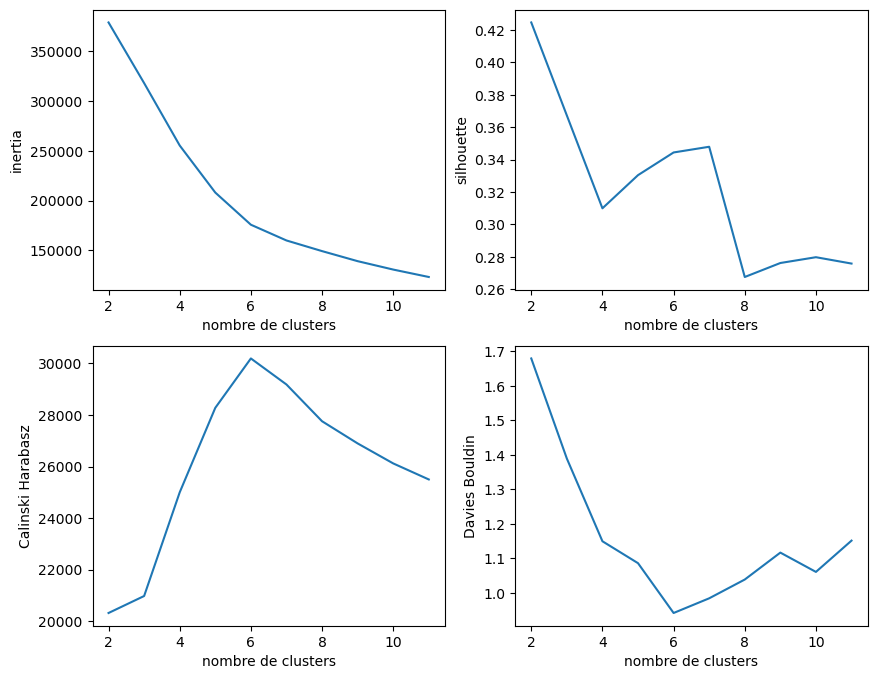

In [79]:
affichage_scores(X_nrm)

Les scores d'inertie, de Davies-Bouldin et de Calinski-Harabasz nous orientent vers un choix de 6 clusters contre 7 pour le score de silhouette.

In [80]:
model_kmeans = KMeans(random_state = 0, n_clusters = 6)
model_kmeans.fit(X_nrm)

KMeans(n_clusters=6, random_state=0)

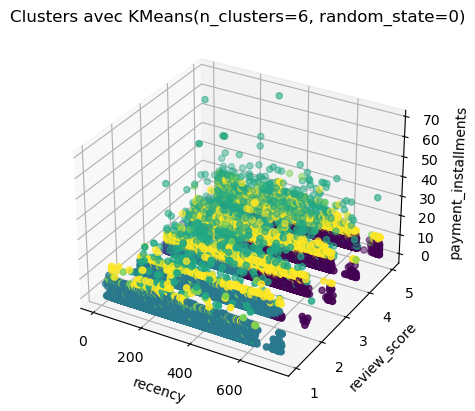

In [81]:
affichage_clusters_3d('recency', 'review_score',
                      'payment_installments', X, model_kmeans)

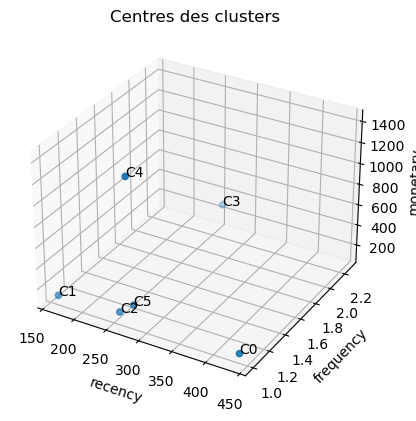

[[4.38233314e+02 1.00000000e+00 1.16826472e+02 4.62563803e+00
  2.09674654e+00]
 [1.62862342e+02 1.00000000e+00 1.17436667e+02 4.69102127e+00
  1.86171998e+00]
 [2.59112381e+02 1.00000000e+00 1.47966263e+02 1.65017668e+00
  2.78057230e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.80874899e+02 1.00000000e+00 2.59908914e+02 4.54039996e+00
  8.26553672e+00]]


In [82]:
affichage_centres_3d(0, 1, 2, model_kmeans)

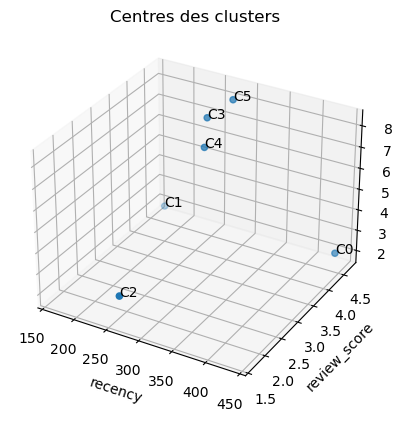

[[4.38233314e+02 1.00000000e+00 1.16826472e+02 4.62563803e+00
  2.09674654e+00]
 [1.62862342e+02 1.00000000e+00 1.17436667e+02 4.69102127e+00
  1.86171998e+00]
 [2.59112381e+02 1.00000000e+00 1.47966263e+02 1.65017668e+00
  2.78057230e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.80874899e+02 1.00000000e+00 2.59908914e+02 4.54039996e+00
  8.26553672e+00]]


In [83]:
affichage_centres_3d(0, 3, 4, model_kmeans)

Les 6 centres :
    
    - C0 représente le clusters des anciens clients. Ils ont passés peu de commandes, sont satisfaits, peu dépensiers et étalent peu leurs paiements
    - C1 représente le clusters des nouveaux clients. Ils sont satisfaits, peu dépensiers et étalent peu leurs paiements
    - C2 représente le clusters des clients insatisfaits.
    - C3 représente le clusters des clients fréquents. Ils sont satisfaits et étalent leurs paiements
    - C4 représente le clusters des clients les plus dépensiers. Ils sont récents, fréquents, satisfaits et étalent leurs paiements
    - C5 représente le clusters des clients peu dépensiers, satisfaits et qui étalent beaucoup leurs paiements

In [84]:
# Affichons la répartition des clients selon leur cluster

pd.Series(model_kmeans.labels_).value_counts()

1    36955
0    25663
2    14432
5    11150
3     2800
4     1493
Name: count, dtype: int64

In [85]:
resultats_rfm_review_payment = pd.DataFrame(
    index = ['Davies_bouldin','Silhouette','calinski_harabasz'])
resultats_rfm_review_payment['KMeans'] = scores_finaux(X_nrm,model_kmeans)


In [86]:
resultats_rfm_review_payment

KMeans
Davies_bouldin         0.941799
Silhouette             0.344389
calinski_harabasz  30193.228721

### <a name="4b"> DBSCAN

In [87]:
model_dbscan = DBSCAN()
model_dbscan.fit(X_nrm)

DBSCAN()

In [88]:
labels = model_dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 44
Estimated number of noise points: 1760


44 clusters !!!

### <a name="4c"> AgglomerativeClustering

In [89]:
# Je ne prends qu'un échantillon de 10%

X_sample = X.sample(frac = 0.1, random_state = 0)
X_nrm_sample = std.fit_transform(X_sample)

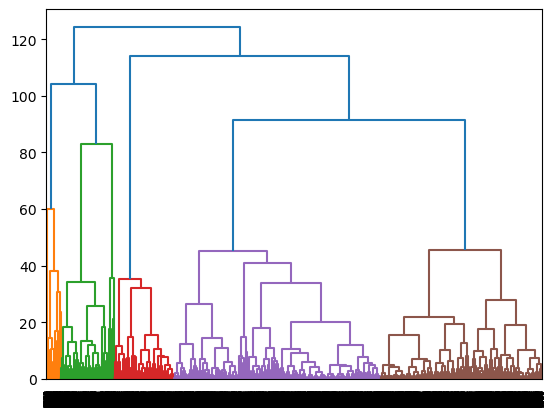

In [90]:
linkage_matrix = linkage(X_nrm_sample, method='ward')
dendrogram(linkage_matrix) 
plt.show()

In [91]:
model_hac = AgglomerativeClustering(n_clusters = 5)
model_hac.fit(X_nrm_sample)

AgglomerativeClustering(n_clusters=5)

In [92]:
resultats_rfm_review_payment['AgglomerativeClustering'] = \
scores_finaux(X_nrm_sample,model_hac)

In [93]:
resultats_rfm_review_payment

KMeans  AgglomerativeClustering
Davies_bouldin         0.941799                 1.150981
Silhouette             0.344389                 0.279077
calinski_harabasz  30193.228721              2463.762601

 KMeans a les meilleurs scores

## <a name="5"> Dataset RFM + review + days_late

In [94]:
X = data[['recency','frequency','monetary','review_score','days_late']]

In [95]:
std = StandardScaler()
X_nrm = std.fit_transform(X)

### <a name="5b"> KMeans

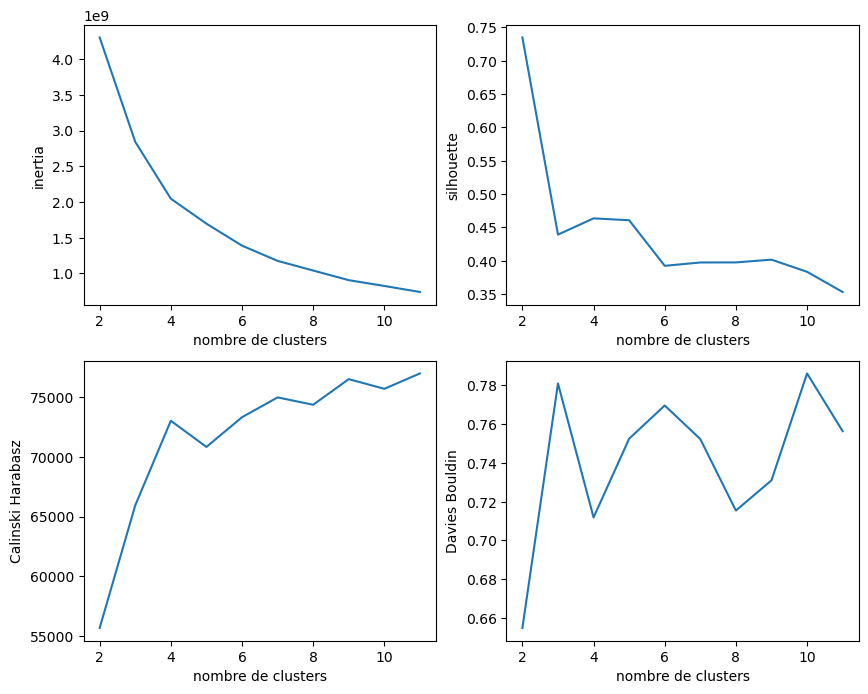

In [96]:
affichage_scores(X)

Les scores d'inertie et de Calinski nous orientent vers un choix de 7 clusters, les scores silhouette et Davies-Bouldin vers 4 clusters.

In [97]:
model_kmeans = KMeans(n_clusters = 4)
model_kmeans.fit(X_nrm)

KMeans(n_clusters=4)

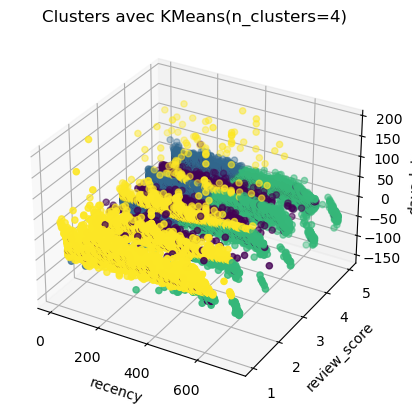

In [98]:
affichage_clusters_3d('recency', 'review_score', 'days_late', X, model_kmeans)

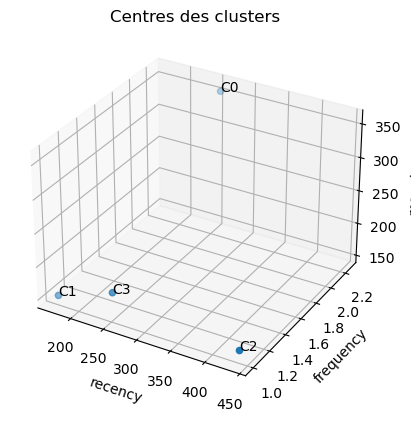

[[257.79055944   2.25559441 355.7061958    4.20070319 -12.64744866]
 [168.77469655   1.         153.14248627   4.65878887 -12.71686453]
 [438.53929744   1.         157.844391     4.57711753 -14.49340118]
 [252.63586453   1.0001426  183.97175686   1.59700535  -3.42053476]]


In [99]:
affichage_centres_3d(0, 1, 2, model_kmeans)

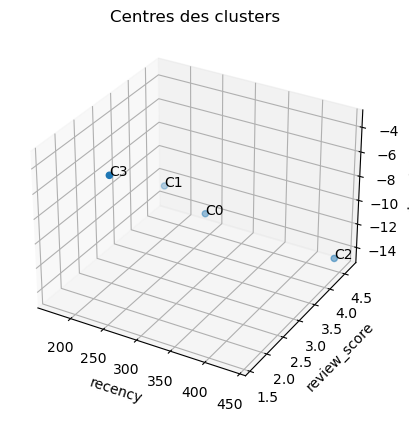

[[257.79055944   2.25559441 355.7061958    4.20070319 -12.64744866]
 [168.77469655   1.         153.14248627   4.65878887 -12.71686453]
 [438.53929744   1.         157.844391     4.57711753 -14.49340118]
 [252.63586453   1.0001426  183.97175686   1.59700535  -3.42053476]]


In [100]:
affichage_centres_3d(0, 3, 4, model_kmeans)

In [101]:
resultats_rfm_review_late = pd.DataFrame(
    index = ['Davies_bouldin','Silhouette','calinski_harabasz'])
resultats_rfm_review_late['KMeans'] = scores_finaux(X_nrm,model_kmeans)
resultats_rfm_review_late

KMeans
Davies_bouldin         1.118139
Silhouette             0.296000
calinski_harabasz  25387.166185

### <a name="5b"> DBSCAN

In [102]:
model_dbscan = DBSCAN()
model_dbscan.fit(X_nrm)

DBSCAN()

In [103]:
labels = model_dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 40
Estimated number of noise points: 1690


40 clusters !!!

### <a name="5c"> AgglomerativeClustering

In [104]:
# Je ne prends qu'un échantillon de 10%

X_sample = X.sample(frac = 0.1, random_state = 0)
X_nrm_sample = std.fit_transform(X_sample)

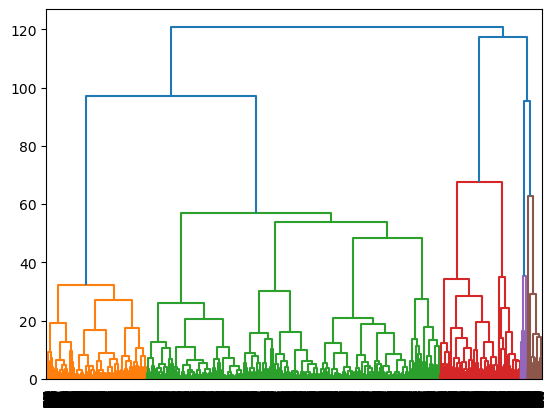

In [105]:
linkage_matrix = linkage(X_nrm_sample, method='ward')
dendrogram(linkage_matrix) 
plt.show()

In [106]:
model_hac = AgglomerativeClustering(n_clusters = 5)
model_hac.fit(X_nrm_sample)

AgglomerativeClustering(n_clusters=5)

In [107]:
resultats_rfm_review_late['AgglomerativeClustering'] = \
scores_finaux(X_nrm_sample,model_hac)

In [108]:
resultats_rfm_review_late

KMeans  AgglomerativeClustering
Davies_bouldin         1.118139                 1.028581
Silhouette             0.296000                 0.280926
calinski_harabasz  25387.166185              2374.423981

 Les scores sont très proches

## <a name="6"> Comparaison

In [109]:
resultats

KMeans       DBSCAN  AgglomerativeClustering
Davies_bouldin         0.703858     1.372827                 0.776409
Silhouette             0.497163     0.659996                 0.460955
calinski_harabasz  55445.270254  3896.545566              5168.318086

In [110]:
resultats_rfm_reviews

KMeans       DBSCAN  AgglomerativeClustering
Davies_bouldin         0.804853     1.659509                 0.960252
Silhouette             0.416110     0.137079                 0.318398
calinski_harabasz  44025.276445  3740.409590              3285.513041

In [111]:
resultats_rfm_review_payment

KMeans  AgglomerativeClustering
Davies_bouldin         0.941799                 1.150981
Silhouette             0.344389                 0.279077
calinski_harabasz  30193.228721              2463.762601

In [112]:
resultats_rfm_review_late

KMeans  AgglomerativeClustering
Davies_bouldin         1.118139                 1.028581
Silhouette             0.296000                 0.280926
calinski_harabasz  25387.166185              2374.423981

Je vais séléctionner les variables RFM, review_score et payment_installments et utiliser KMeans.

## <a name="7"> Hyper-paramètres et stabilité

In [113]:
X = data[['recency','frequency','monetary',
          'review_score','payment_installments']]

In [114]:
std = StandardScaler()
X_nrm = std.fit_transform(X)

Testons plusieurs hyper-paramètres et vérifions la stabilité

In [115]:
def test_param(init, max_iter, n_init, tol):
    '''Teste la stabilité de KMeans avec les hyper-paramètres donnés.'''
    
    for i in range(5):
        model = KMeans(n_clusters = 6, init = init,
                       max_iter = max_iter, n_init = n_init, tol = tol)
        model.fit(X_nrm)
        print(pd.Series(model.labels_).value_counts())

In [116]:
test_param('random', 100, 10, 0.0001)

5    36932
4    25642
0    14455
3    11149
2     2800
1     1515
Name: count, dtype: int64
5    36921
2    25638
4    14453
0    11146
1     2800
3     1535
Name: count, dtype: int64
2    36957
5    25635
0    14412
1    11156
4     2799
3     1534
Name: count, dtype: int64
1    36957
2    25635
0    14412
5    11156
4     2799
3     1534
Name: count, dtype: int64
0    36954
5    25636
4    14414
1    11156
3     2799
2     1534
Name: count, dtype: int64


Les effectifs varient trop. Le modèle est instable.

In [117]:
test_param('k-means++', 300, 5, 0.0001)

0    36980
3    25622
1    14442
4    11153
2     2800
5     1496
Name: count, dtype: int64
5    36957
0    25635
1    14412
4    11156
2     2799
3     1534
Name: count, dtype: int64
0    36929
1    25672
2    14437
3    11145
5     2800
4     1510
Name: count, dtype: int64
4    36963
1    25640
5    14396
0    11161
3     2799
2     1534
Name: count, dtype: int64
3    37096
0    25532
4    14394
1    11174
5     2800
2     1497
Name: count, dtype: int64


Les effectifs des clusters varient. Le model est instable.

In [118]:
test_param('k-means++', 300, 15, 0.0001)

2    36949
1    25624
3    14484
5    11143
0     2800
4     1493
Name: count, dtype: int64
5    36986
1    25665
0    14398
2    11149
4     2800
3     1495
Name: count, dtype: int64
5    36955
2    25664
0    14433
4    11148
3     2800
1     1493
Name: count, dtype: int64
3    36955
2    25664
1    14433
0    11148
4     2800
5     1493
Name: count, dtype: int64
1    36955
0    25663
3    14432
2    11150
4     2800
5     1493
Name: count, dtype: int64


Les effectifs sont sensiblement les mêmes. Le modèle est stable.

Affichons les centroïdes des clusters

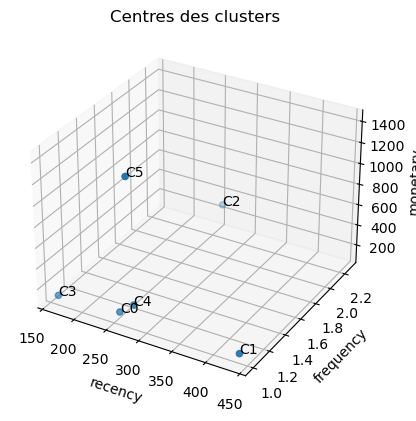

[[2.59209625e+02 1.00000000e+00 1.47951623e+02 1.64905346e+00
  2.78136052e+00]
 [4.38233314e+02 1.00000000e+00 1.16826472e+02 4.62563803e+00
  2.09674654e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [1.62855651e+02 1.00000000e+00 1.17452289e+02 4.69047233e+00
  1.86171076e+00]
 [2.80874899e+02 1.00000000e+00 2.59908914e+02 4.54039996e+00
  8.26553672e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]]


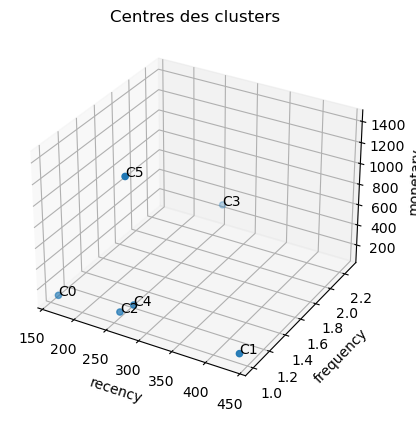

[[1.62847737e+02 1.00000000e+00 1.17456138e+02 4.68974096e+00
  1.86177059e+00]
 [4.38228270e+02 1.00000000e+00 1.16824581e+02 4.62551136e+00
  2.09673900e+00]
 [2.59321114e+02 1.00000000e+00 1.47983312e+02 1.64736513e+00
  2.78233701e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [2.80874899e+02 1.00000000e+00 2.59908914e+02 4.54039996e+00
  8.26553672e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]]


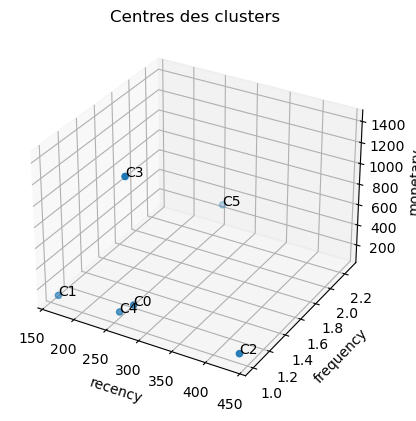

[[2.80855849e+02 1.00000000e+00 2.59854365e+02 4.54045569e+00
  8.26632580e+00]
 [1.62922176e+02 1.00000000e+00 1.17450310e+02 4.69159789e+00
  1.86123664e+00]
 [4.38300838e+02 1.00000000e+00 1.16834853e+02 4.62553109e+00
  2.09717404e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.58989270e+02 1.00000000e+00 1.47962377e+02 1.65129803e+00
  2.78116996e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]]


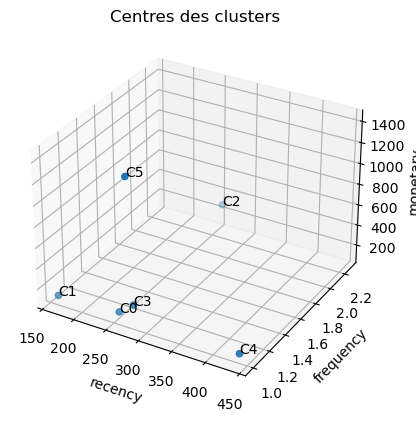

[[2.58761483e+02 1.00000000e+00 1.47961924e+02 1.65273935e+00
  2.78050636e+00]
 [1.63161567e+02 1.00000000e+00 1.17422288e+02 4.69270693e+00
  1.86046386e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [2.80796647e+02 1.00000000e+00 2.59583576e+02 4.53985475e+00
  8.26513046e+00]
 [4.38661249e+02 1.00000000e+00 1.16865733e+02 4.62452631e+00
  2.09743329e+00]
 [2.67176825e+02 1.03348962e+00 1.41198577e+03 3.94686314e+00
  6.66510382e+00]]


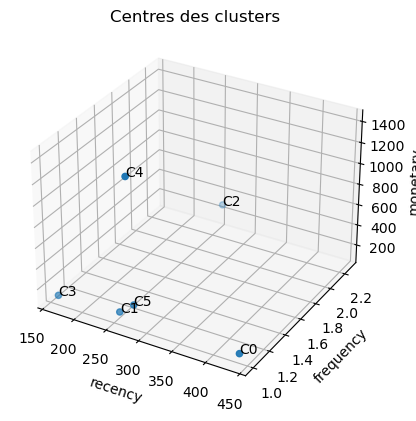

[[4.38226972e+02 1.00000000e+00 1.16817350e+02 4.62562344e+00
  2.09655549e+00]
 [2.59112381e+02 1.00000000e+00 1.47966263e+02 1.65017668e+00
  2.78057230e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [1.62862342e+02 1.00000000e+00 1.17436667e+02 4.69102127e+00
  1.86171998e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.80903605e+02 1.00000000e+00 2.59917076e+02 4.54044118e+00
  8.26542324e+00]]


In [119]:
for i in range(5) :
    model = KMeans(n_clusters = 6, init = 'k-means++',
                   max_iter = 300, n_init = 15, tol = 0.0001)
    model.fit(X_nrm)
    affichage_centres_3d(0, 1, 2, model)

Les centroïdes se retrouvent aux mêmes positions. Le modèle est stable.

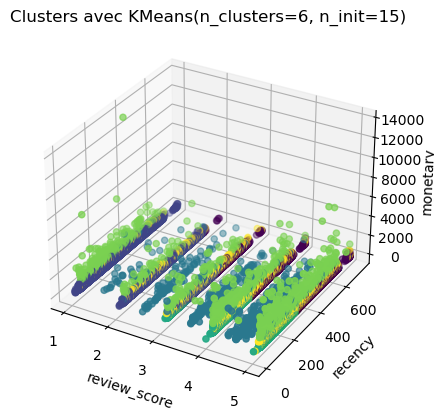

In [120]:
affichage_clusters_3d('review_score', 'recency', 'monetary', X, model)

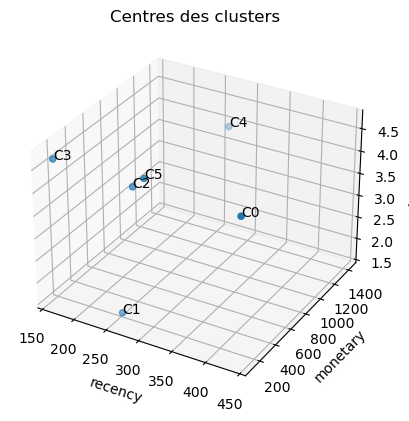

[[4.38226972e+02 1.00000000e+00 1.16817350e+02 4.62562344e+00
  2.09655549e+00]
 [2.59112381e+02 1.00000000e+00 1.47966263e+02 1.65017668e+00
  2.78057230e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [1.62862342e+02 1.00000000e+00 1.17436667e+02 4.69102127e+00
  1.86171998e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.80903605e+02 1.00000000e+00 2.59917076e+02 4.54044118e+00
  8.26542324e+00]]


In [121]:
affichage_centres_3d(0, 2, 3, model)

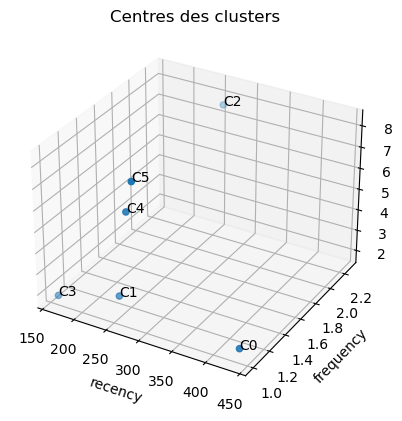

[[4.38226972e+02 1.00000000e+00 1.16817350e+02 4.62562344e+00
  2.09655549e+00]
 [2.59112381e+02 1.00000000e+00 1.47966263e+02 1.65017668e+00
  2.78057230e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [1.62862342e+02 1.00000000e+00 1.17436667e+02 4.69102127e+00
  1.86171998e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.80903605e+02 1.00000000e+00 2.59917076e+02 4.54044118e+00
  8.26542324e+00]]


In [122]:
affichage_centres_3d(0, 1, 4, model)

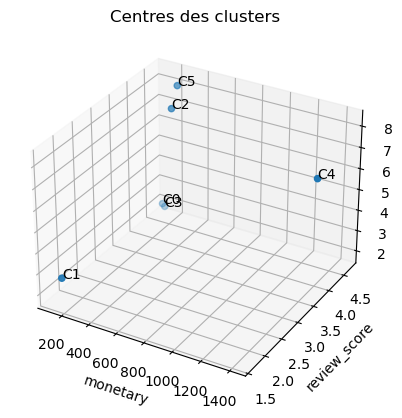

[[4.38226972e+02 1.00000000e+00 1.16817350e+02 4.62562344e+00
  2.09655549e+00]
 [2.59112381e+02 1.00000000e+00 1.47966263e+02 1.65017668e+00
  2.78057230e+00]
 [2.58056786e+02 2.26535714e+00 3.00728746e+02 4.20440873e+00
  7.65535714e+00]
 [1.62862342e+02 1.00000000e+00 1.17436667e+02 4.69102127e+00
  1.86171998e+00]
 [2.67254362e+02 1.03355705e+00 1.41312273e+03 3.94474273e+00
  6.66375839e+00]
 [2.80903605e+02 1.00000000e+00 2.59917076e+02 4.54044118e+00
  8.26542324e+00]]


In [123]:
affichage_centres_3d(2, 3, 4, model)

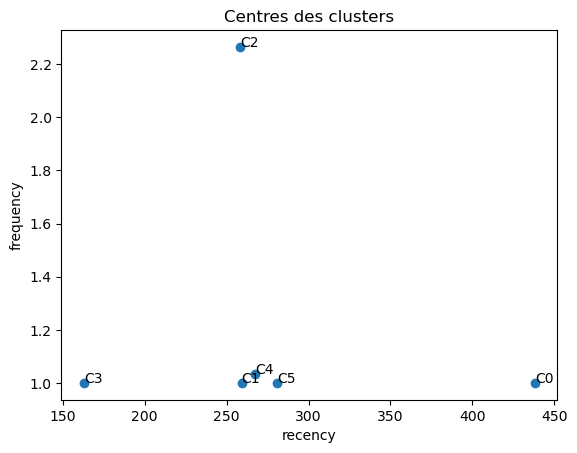

In [124]:
model_kmeans = model
affichage_centres_2d(0, 1)

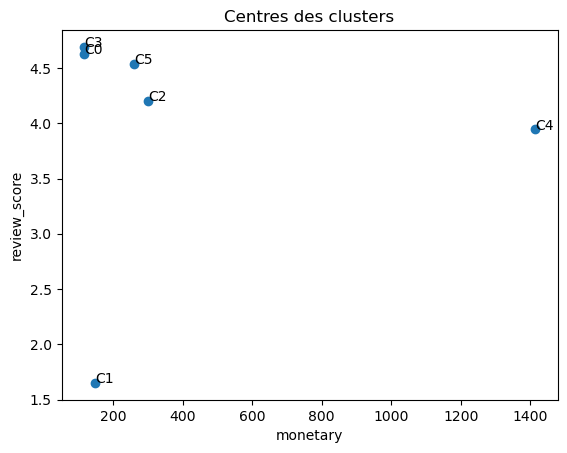

In [125]:
affichage_centres_2d(2, 3)

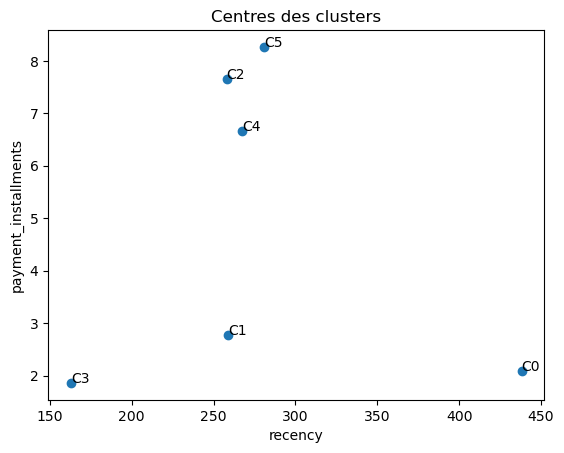

In [126]:
affichage_centres_2d(0, 4)

Les 6 centres :

     - C0 représente le cluster des anciens clients. Ils sont très satisfaits, occasionnels, dépensent peu et n'étalent pas leurs paiements.
     - C1 représente le cluster des clients récents. Ils sont très satisfaits, occasionnels, dépensent peu et n'étalent pas leurs paiements.
     - C2 représente le cluster des clients insatisfaits. Ils sont occasionnels, dépensent peu et étalent peu leurs paiements.
     - C3 représente le cluster des clients fréquents. Ils sont satisfaits et étalent beaucoup leurs paiements.
     - C4 représente le cluster des clients occasionnels, très satisfaits, qui dépensent peu et qui étalent beaucoup leurs paiements.
     - C5 représente le cluster des clients qui dépensent le plus. Ils sont occasionnels, plutôt satisfaits et étalent leurs paiements.